This notebook contains a simple example of diffusion.  We follow the general DDPM/DDIM setup.  We will be mapping between a normal distribution and a simple target distribution specified by 10 data points. We will use a predefined MLP network from the `torchcfm` library, so make sure this is install before running the notebook.

In [ ]:
%pip install torchcfm

# Dataset

First, we will define our target distributions.

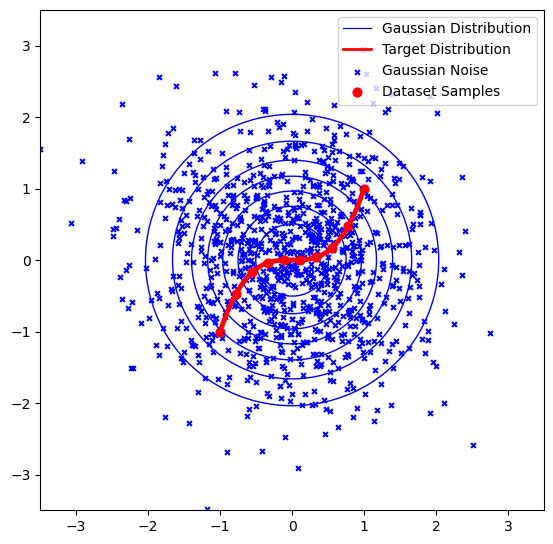

In [9]:
import numpy as np
import matplotlib.pyplot as plt
from torchcfm.models.models import *
import torch
from matplotlib.lines import Line2D

# Plot noise
noise = np.random.randn(1000,2)
plt.figure(figsize=(6.5, 6.5))

x = np.linspace(-3.5, 3.5, 100)
y = np.linspace(-3.5, 3.5, 100)
X, Y = np.meshgrid(x, y)

# Define the standard normal distribution function
Z = (1 / (2 * np.pi)) * np.exp(-0.5 * (X**2 + Y**2))

# Create the contour plot
contours = plt.contour(X, Y, Z, colors="blue", linewidths=1)  # all lines are orange

# Create a custom line handle for the legend
line_for_legend = Line2D([0], [0], color="blue", lw=0.9)
line_for_legend_2 = Line2D([0], [0], color="red", lw=2)

s1 = plt.scatter(noise[:,0], noise[:,1], marker='x', s=12, label='Gaussian Samples', c='blue')

# Create x values from -1 to 1
xs = np.linspace(-1, 1, 100)

# Calculate y values
ys = xs**3

# Create the plot
plt.plot(xs, ys, label='Target Distribution', c='red', lw=3.5)

# Create x values from -1 to 1
dataset_size = 10
xs = np.linspace(-1, 1, dataset_size)

# Calculate y values
ys = xs**3

s2 = plt.scatter(xs, ys, label='Dataset Samples', s=40, c='red')


# Set the axis limits
plt.xlim(-3.5, 3.5)
plt.ylim(-3.5, 3.5)

# Add labels
plt.legend([line_for_legend, line_for_legend_2, s1, s2], ["Gaussian Distribution", "Target Distribution", "Gaussian Noise", "Dataset Samples"], loc="upper right")
#plt.savefig('./diffusion_datasets.png', dpi=300)
# Show the plot
plt.show()

# Train Model

We will define a diffusion network as a simple MLP.  The input must be the same size as the output.

In [10]:
# Neural network
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = MLP(dim=2, time_varying=True)
model = model.to(device)

Now, lets define our hyperparameters.

In [11]:
# Hyperparameters
bs = 256

# Optimizer
optimizer = torch.optim.Adam(model.parameters(), lr=1e-4)

In [12]:
# Noise schedule
beta_start = 0.0001
beta_end = 0.02
timesteps = 1000
betas = torch.linspace(beta_start, beta_end, timesteps).to(device)
alphas = 1. - betas
alphas_cumprod = torch.cumprod(alphas, axis=0)

___
### **Algorithm 2** Sampling
___
1. &nbsp;$x_T \sim \mathcal{N}(0, I)$
2. &nbsp;$\textbf{for } t=T,...,1 \textbf{ do}$
3. &nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp; $\epsilon \sim \mathcal{N}(0, I) \text{ if } t>1, \text{ else } \epsilon=0$
4. &nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp; ${x}_{t-1}=\sqrt{\alpha_{t-1}} \left( \frac{{x}_t-\sqrt{1-\alpha_t}D_{\theta}(x_t,t)}{\sqrt{\alpha_t}} \right) + \sqrt{1-\alpha_{t-1}-\sigma_t} D_{\theta}(x_t,t) + \sigma_t\epsilon$
5. &nbsp;$\textbf{end for}$
6. &nbsp;$\textbf{return } x_0$
___

In [13]:
# Sampling
@torch.no_grad()
def sample(x, add_noise=False):
    
    # Inference : Markov chain with T steps
    markov_chain = torch.zeros(timesteps+1, x.shape[0], x.shape[1])
    markov_chain[0] = x
    for i in reversed(range(timesteps)):

        # Get the correct shape for timesteps t
        t = torch.full((x.shape[0],), i, dtype=torch.long).to(device)

        # Run neural network
        model_input = torch.concat([x, t[:,None] / timesteps], axis=1).float()
        predicted_noise = model(model_input)

        # Equation 12 - Denoising Diffusion Implicit Models (https://arxiv.org/pdf/2010.02502)
        alpha_cumprod = alphas_cumprod[t][:, None]
        alpha_cumprod_minus_1 = (torch.tensor(1.0) if i == 0 else alphas_cumprod[t-1][:, None])
        if add_noise == True:
            noise_scaler = 16
            sigma_t = torch.sqrt((1-alpha_cumprod_minus_1)/(1-alpha_cumprod)) * torch.sqrt(1-(alpha_cumprod/alpha_cumprod_minus_1)) / noise_scaler
        else:
            sigma_t = 0
        x = torch.sqrt(alpha_cumprod_minus_1) * ((x - torch.sqrt(1 - alpha_cumprod) * predicted_noise) / torch.sqrt(alpha_cumprod)) + \
            torch.sqrt(1 - alpha_cumprod_minus_1 - sigma_t**2) * predicted_noise + \
            sigma_t * torch.randn_like(x)
        markov_chain[timesteps - i] = x.cpu()

    return markov_chain



___
### **Algorithm 1** Training
___
1. &nbsp;$\textbf{repeat}$
2. &nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp; $x_0 \sim q(x_0)$ 
3. &nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp; $t \sim \mathcal{U}(\{1,...,T\})$
4. &nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp; $\epsilon \sim \mathcal{N}(0, I)$
5. &nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp; $x_t = \sqrt{\alpha_t} x_0 + \sqrt{1-\alpha_t} \epsilon$
6. &nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp; $\text{Take gradient step on}$
7. &nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp; $\nabla_\theta \|D_\theta(x_t, t) - \epsilon\|^2 $
___

In [14]:
def train_step(data, t):
    # Corrupt with noise
    noise = torch.randn_like(data).float()
    noisy_data = torch.sqrt(alphas_cumprod[t])[:, None] * data + \
              torch.sqrt(1 - alphas_cumprod[t])[:, None] * noise
    
    # Run neural network
    model_input = torch.concat([noisy_data, t[:,None] / timesteps], axis=1).float()
    noise_pred = model(model_input)
    
    # Calculate and return loss
    loss = torch.nn.functional.mse_loss(noise_pred, noise)
    return loss

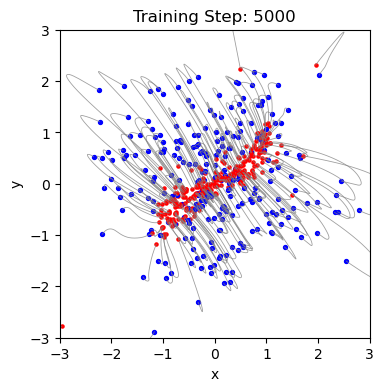

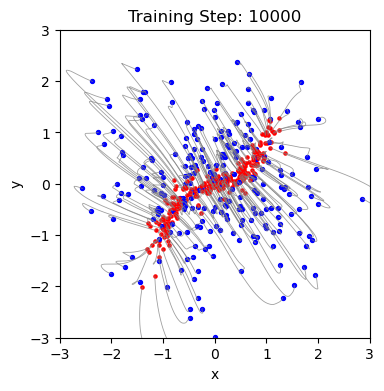

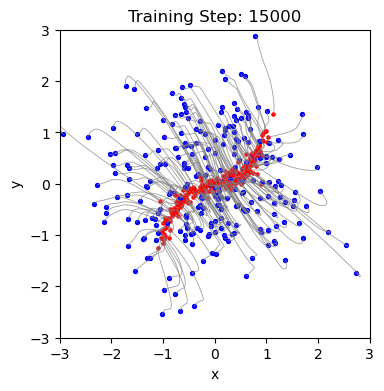

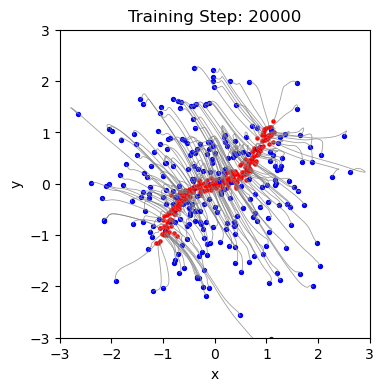

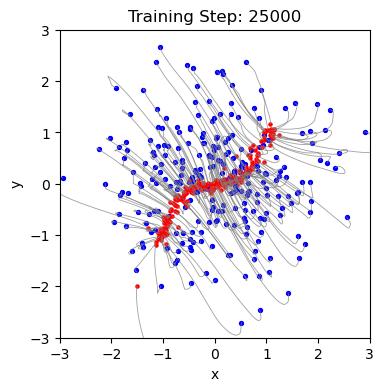

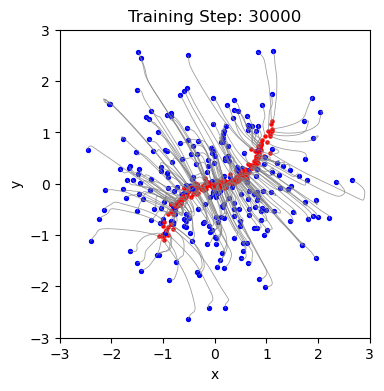

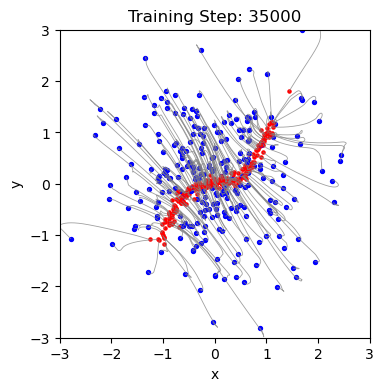

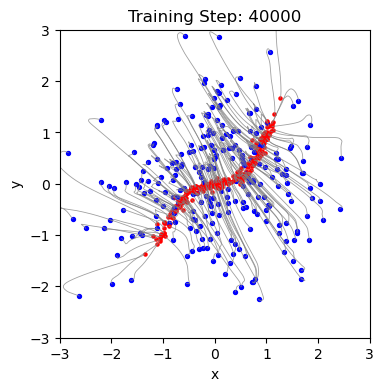

In [15]:
for step in range(40000):
    # Prepare data
    sample_idx = np.random.randint(0, xs.size, bs)
    x, y = torch.tensor(xs[sample_idx]), torch.tensor(ys[sample_idx])
    x, y = x.to(device), y.to(device)
    data = torch.concat([x[:,None], y[:,None]], axis=1)
    
    # Timesteps
    t = torch.randint(0, timesteps, (x.shape[0],)).to(device)
    
    # Forward pass
    loss = train_step(data, t)
    
    # Backwards pass
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()
    
    if (step+1) % 5000 == 0:
        # Generate samples
        noise = torch.randn_like(data).float()
        samples = sample(noise)

        # Plot samples
        plt.figure(figsize=(4, 4))
        for s in range(samples.shape[1]):
            plt.plot(samples[:,s,0], samples[:,s,1], c='grey', linewidth=0.6, alpha=0.75)
            plt.scatter(samples[0,s,0], samples[0,s,1], c='blue', s=8)
            plt.scatter(samples[-1,s,0], samples[-1,s,1], c='red', s=5)
        plt.xlim(-3, 3)
        plt.ylim(-3, 3)
        plt.xlabel('x')
        plt.ylabel('y')
        plt.title('Training Step: ' + str(step+1))
        plt.show()

# Inference

Now our model is trained lets compare deterministic sampling to stochastic sampling.  Deterministic sampling will produce smooth diffusion mapping, were as stochastic sampling will add a small amount of noise at every step of the diffusion process.

/tmp/ipykernel_86809/2051237678.py:11: UserWarning: Legend does not support handles for list instances.
A proxy artist may be used instead.
See: https://matplotlib.org/stable/users/explain/axes/legend_guide.html#controlling-the-legend-entries
  plt.legend([p1, s1, s2], ["Diffusion Trajectory", "$x_T$", "$x_0$", "Dataset Samples"], loc="upper right")


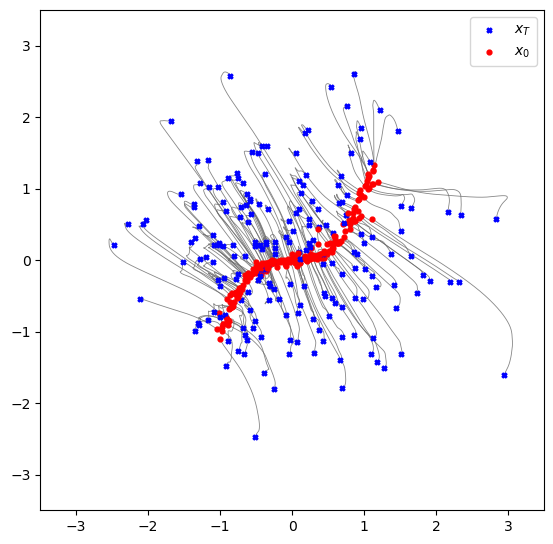

In [16]:
# Generate samples
noise = torch.randn(200, 2).to(data.device).float()
samples = sample(noise, False)

# Plot samples
plt.figure(figsize=(6.5, 6.5))
for s in range(samples.shape[1]):
    p1 = plt.plot(samples[:,s,0], samples[:,s,1], c='dimgrey', linewidth=0.6, alpha=0.8, zorder=-1)
    s1 = plt.scatter(samples[0,s,0], samples[0,s,1], c='blue', s=12, marker='X')
    s2 = plt.scatter(samples[-1,s,0], samples[-1,s,1], c='red', s=12)
plt.legend([p1, s1, s2], ["Diffusion Trajectory", "$x_T$", "$x_0$", "Dataset Samples"], loc="upper right")
#plt.savefig('./diffusion_deterministic.png', dpi=300)
plt.xlim(-3.5, 3.5)
plt.ylim(-3.5, 3.5)
plt.show()


/tmp/ipykernel_86809/674819736.py:9: UserWarning: Legend does not support handles for list instances.
A proxy artist may be used instead.
See: https://matplotlib.org/stable/users/explain/axes/legend_guide.html#controlling-the-legend-entries
  plt.legend([p1, s1, s2], ["Diffusion Trajectory", "$x_T$", "$x_0$", "Dataset Samples"], loc="upper right")


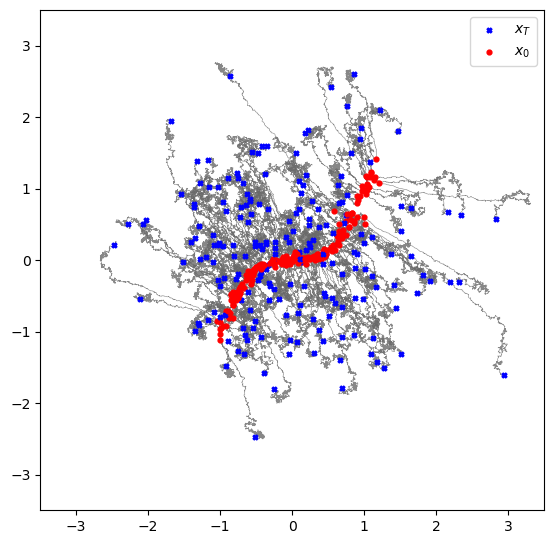

In [17]:
samples = sample(noise, True)

# Plot samples
plt.figure(figsize=(6.5, 6.5))
for s in range(samples.shape[1]):
    p1 = plt.plot(samples[:,s,0], samples[:,s,1], c='dimgrey', linewidth=0.4, alpha=0.8, zorder=-1)
    s1 = plt.scatter(samples[0,s,0], samples[0,s,1], c='blue', s=12, marker='X')
    s2 = plt.scatter(samples[-1,s,0], samples[-1,s,1], c='red', s=12)
plt.legend([p1, s1, s2], ["Diffusion Trajectory", "$x_T$", "$x_0$", "Dataset Samples"], loc="upper right")
#plt.savefig('./diffusion_stochastic.png', dpi=300)
plt.xlim(-3.5, 3.5)
plt.ylim(-3.5, 3.5)
plt.show()